# Transfer Learning

(The data for this demo can be downloaded here: https://drive.google.com/file/d/1uRU3jSSv6r7KvuzsCforSzq0-kNuDctI/view?usp=sharing)

The learning goals of this tutorial are:

- Illustrate the transfer learning procedure using a model pre-trained on [ImageNet](http://www.image-net.org/).
- Get familiar with the Keras API to load pre-trained models and freeze layers during training.

## Step-by-step Procedure

1. Load dataset, explore it (display images, mean, min, max values, etc.) and split it into train, validation and test sets
2. Data scaling (use the same scaling technique as the one the pretrained model originally used)
    - [tf.keras.applications.resnet.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input)
3. One hot encoding
4. Define your callbacks (save your model, patience, etc.)
5. Set up data Augmentation

6. Transfer Learning
    
    6.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)
    
    6.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model
    
    6.3. Add a top (i.e., the prediction layers)
    
    6.4  Train the model using your dataset
    
    6.5 Unfreeze the layers and fine-tune the whole model (i.e., train your model with a very small learning rate)
    
    6.6 If you are satisfied with the train and validation performance go to the next step
    
    6.7 If you are not satisfied with the train and validation performance go back to step 6.1.

7. Test your model on the test and extract relevant metrics

In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pylab as plt
import pickle

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1. Set up your data augmentation

In [2]:
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

# Train and validation generators
train_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
val_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]

bs = 64 # batch size

train_generator = train_gen.flow_from_directory(
    directory = "C:\\Users\\rober\\OneDrive\\Documents\\GitHub\\ENEL645\\Data\\Garbage-dataset\\Train",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

validation_generator = val_gen.flow_from_directory(
    directory = "C:\\Users\\rober\\OneDrive\\Documents\\GitHub\\ENEL645\\Data\\Garbage-dataset\\Validation",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",)

Found 5139 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


## 2. Define your callbacks (save your model, patience, etc.)

In [3]:
model_name_it = "garbage_classifier_en_b0_it.h5"
model_name_ft = "garbage_classifier_en_b0_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 3. Transfer Learning

3.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

3.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model

3.3. Add a top (i.e., the prediction layers)

In [4]:
img_height = 256
img_width = 256

# Defining the model
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

x1 = base_model(base_model.input, training = False)
x2 = tf.keras.layers.Flatten()(x1)


out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 327684    
Total params: 4,377,255
Trainable params: 327,684
Non-trainable params: 4,049,571
_________________________________________________________________
None


## 3.4 Train the model using your dataset

In [5]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_it = model.fit(train_generator, epochs=10, verbose = 1, \
                       callbacks= [early_stop, monitor_it, lr_schedule], \
                       validation_data = (validation_generator))

Epoch 1/10
81/81 [==============================] - 305s 3s/step - loss: 0.8626 - accuracy: 0.6624 - val_loss: 0.5839 - val_accuracy: 0.7801
Epoch 2/10
81/81 [==============================] - 66s 816ms/step - loss: 0.3883 - accuracy: 0.8503 - val_loss: 0.5459 - val_accuracy: 0.8103
Epoch 3/10
81/81 [==============================] - 68s 844ms/step - loss: 0.3384 - accuracy: 0.8732 - val_loss: 0.5479 - val_accuracy: 0.8077
Epoch 4/10
81/81 [==============================] - 65s 807ms/step - loss: 0.2938 - accuracy: 0.8875 - val_loss: 0.5306 - val_accuracy: 0.8094
Epoch 5/10
81/81 [==============================] - 66s 810ms/step - loss: 0.2485 - accuracy: 0.9047 - val_loss: 0.5051 - val_accuracy: 0.8228
Epoch 6/10
81/81 [==============================] - 64s 797ms/step - loss: 0.2340 - accuracy: 0.9091 - val_loss: 0.5197 - val_accuracy: 0.8130
Epoch 7/10
81/81 [==============================] - 64s 790ms/step - loss: 0.2152 - accuracy: 0.9189 - val_loss: 0.5489 - val_accuracy: 0.8183
E

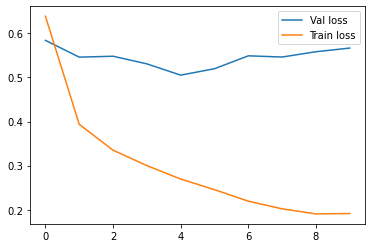

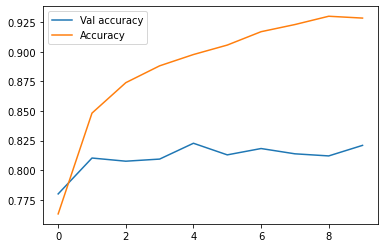

In [6]:
it_file = open("it_history.pkl", "wb")
pickle.dump(history_it.history, it_file)
it_file.close()

plt.figure()
plt.plot(history_it.history["val_loss"], label = "Val loss")
plt.plot(history_it.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()



In [7]:
# Fine-tuning the model
model = tf.keras.models.load_model(model_name_it)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft = model.fit(train_generator, epochs=5, verbose = 1, \
                       callbacks= [early_stop, monitor_ft, lr_schedule], \
                       validation_data = (validation_generator))

Fine-tuning model
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 8, 8, 1280)        4049571   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 327684    
Total params: 4,377,255
Trainable params: 4,335,232
Non-trainable params: 42,023
_________________________________________________________________
None
Epoch 1/5
81/81 [==============================] - 337s 2s/step - loss: 0.2348 - accuracy: 0.9127 - val_loss: 0.5357 - val_accuracy: 0.8148
Epoch 2/5
81/81 [==============================] - 67s 821ms/step - loss: 0.2573 

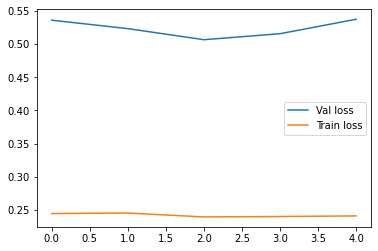

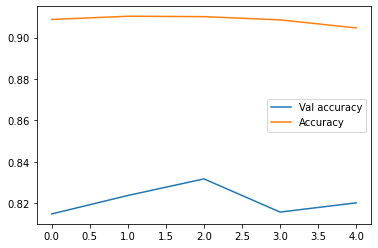

In [8]:
plt.figure()
plt.plot(history_ft.history["val_loss"], label = "Val loss")
plt.plot(history_ft.history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ft.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ft.history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

ft_file = open("ft_history.pkl", "wb")
pickle.dump(history_ft.history, ft_file)
it_file.close()

## 4. Test your model on the test set and extract relevant metrics

In [9]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = "C:\\Users\\rober\\OneDrive\\Documents\\GitHub\\ENEL645\\Data\\Garbage-dataset\\Test",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 629 images belonging to 4 classes.


In [10]:
# Testing the model in the initial training
model = tf.keras.models.load_model(model_name_it)
model.evaluate(test_generator)

# Testing the model in the fine tuning
model = tf.keras.models.load_model(model_name_ft)
model.evaluate(test_generator)


10/10 [==============================] - 8s 654ms/step - loss: 0.6724 - accuracy: 0.7631


[0.6723986268043518, 0.7631160616874695]

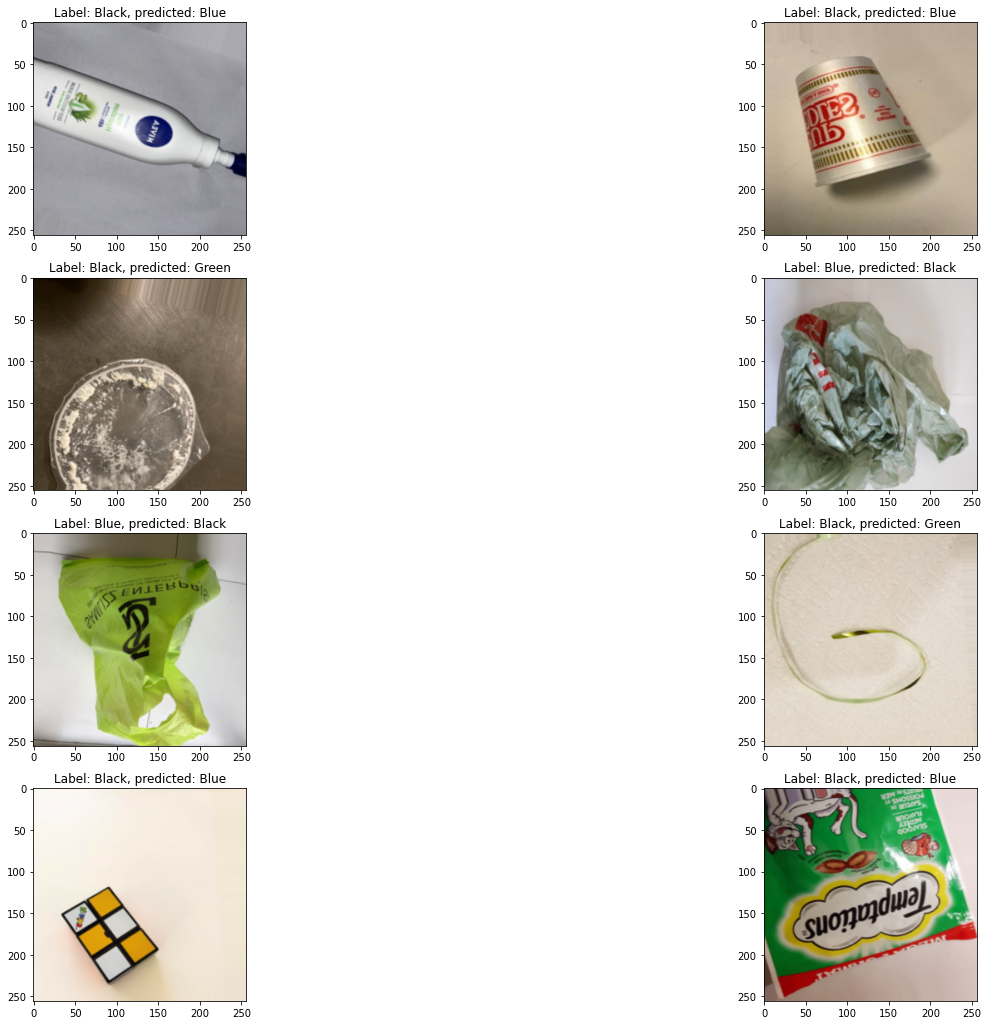

In [12]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()